Only use for making temperature files

In [1]:
from salishsea_tools import rivertools, gsw_calls
import netCDF4 as NC
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
import importlib
importlib.reload(gsw_calls)
importlib.reload(rivertools)

<module 'salishsea_tools.rivertools' from '/ocean/sallen/allen/research/Meopar/Tools/SalishSeaTools/salishsea_tools/rivertools.py'>

In [5]:
#what type of file would you like to create?
#e.g. 'constant' - yearly average used for all months
#     'monthly' - monthly averages used for each month
rivertype = 'monthly'
# what type of river, Long or Short?
length = 'allArms'
#bathymetry
if length == 'long':
    bathyname = 'bathy_downonegrid2.nc'
elif length == 'allArms':
    bathyname = 'bathy_db1_jetty.nc'
else:
    bathyname = 'bathy_meter_SalishSea2.nc'

In [7]:
# set bathymetry
bathy = '../../../nemo-forcing/grid/' + bathyname
# set initialized depth (everywhere its this except where set in prop_dict files)
init_depth = 3.
# set initialized temperature (everywhere its this temperature except where reset)
# for monthly, any value other than -99 will call the rivertemp(month) to set the temperatures
init_temp = 9.

In [5]:
#get river fluxes from netcdf file
if rivertype == 'constant':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_cnst.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array(bathy=bathy, init_depth=init_depth,
                                                              init_temp=init_temp)
if rivertype == 'monthly':
    fluxfile = NC.Dataset('../../../nemo-forcing/rivers/Salish_allrivers_monthly.nc','r')
    #inialise the runoff and run_depth arrays
    runoff, run_depth, run_temp = rivertools.init_runoff_array_monthly(bathy=bathy, 
                                                                       init_depth=init_depth,
                                                                       init_temp=init_temp)

In [6]:
print (run_depth.max(), run_temp.max())

3.0 18.7962798445


In [7]:
# make temperature conservative temperature
# this is terrible inefficient because its doing the full 898 x 398 of uniform temperatures
sal_ref = np.zeros_like(run_temp)

In [8]:
#temp_cons = gsw_calls.generic_gsw_caller('CT_from_PT', sal_ref[0,0], run_temp[0,0]);
temp_cons = gsw_calls._call_CT_from_PT(sal_ref, run_temp);

(12, 898, 398)


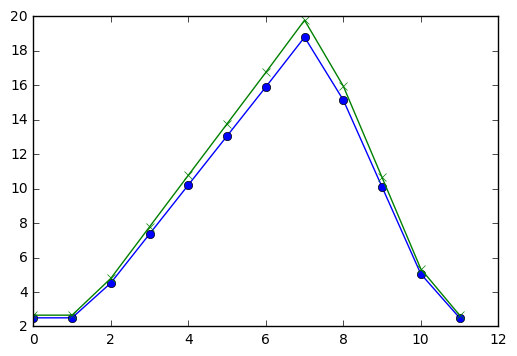

In [9]:
print (temp_cons.shape)
if rivertype == 'monthly':
    plt.plot (run_temp[:,0,0], 'o-')
    plt.plot (temp_cons[:,0,0], 'x-')
else:
    print (temp_cons[15,15])

In [20]:
#get dimensions for netcdf files
fB = NC.Dataset(bathy, 'r')
lat = fB.variables['nav_lat']
lon = fB.variables['nav_lon']
D = fB.variables['Bathymetry'][:]
ymax, xmax = D.shape
print (lat[:].shape)
mesh = NC.Dataset('../../../NEMO-forcing/grid/mesh_mask_downbyone2.nc')
e1t = mesh.variables['e1t'][0,:]
e2t = mesh.variables['e2t'][0,:]
mesh.close()

(898, 398)


In [11]:
# make temperature file
nemo = NC.Dataset('river_ConsTemp_month.nc', 'w')
nemo.description = 'Monthly Average Temperature, Conservative Temperature' 

# dimensions
nemo.createDimension('x', xmax)
nemo.createDimension('y', ymax)
nemo.createDimension('time_counter', None)
    
# variables
# latitude and longitude
nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
nav_lat = lat
    
nav_lon = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
nav_lon = lon

# time
time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
time_counter.units = 'non-dim'
time_counter[0:12] = range(1,13)

# temperature
rotemper = nemo.createVariable('rotemper','float32',('time_counter','y','x'),zlib=True)
rotemper._Fillvalue = -99.
rotemper.missing_value = -99.
rotemper.units = 'deg C'
rotemper.longname = 'Conservative Temperature'
rotemper[0:12,:] = temp_cons
    
nemo.close()

In [12]:
#list of watersheds we are including
names = ['skagit', 'fraser', 'evi_n', 'howe', 'bute', 'puget', 'jdf', 'evi_s', 'jervis', 'toba']

In [13]:
for name in range(0,len(names)):
    watershedname = names[name]
    print (watershedname)
    Flux = fluxfile.variables[watershedname][:]
    if rivertype == 'constant':
        Flux = float(Flux)
    runoff_orig = np.copy(runoff)
    runoff, run_depth, run_temp = rivertools.put_watershed_into_runoff(rivertype,
                                            watershedname, Flux, runoff, run_depth, temp_cons,
                                            Fraser_River=length)
    if rivertype == 'constant':
        rivertools.check_sum(runoff_orig, runoff, Flux)
    if rivertype == 'monthly':
        rivertools.check_sum_monthly(runoff_orig, runoff, Flux)

skagit
908.655847841 937.969
fraser
3623.96436841 3539.81
evi_n
255.803942635 638.889
howe
587.571269457 571.458
bute
606.331691748 547.856
puget
481.252250068 503.333
jdf
400.914077215 411.162
evi_s
331.941328263 330.787
jervis
307.500474383 296.967
toba
285.070089693 269.932


3.0 19.783
8.97165904


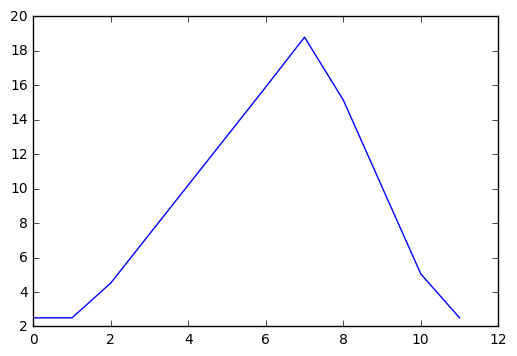

In [14]:
print (run_depth.max(), temp_cons.max())
if rivertype=='monthly':
    plt.plot(temp_cons[:,351,345])
    print (np.mean(temp_cons[:,351,345]))

In [15]:
if rivertype == 'constant':
    
    if length == 'short':
        nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst.nc', 'w')
        nemo.description = 'Constant Yearly Average, All Rivers, Short Fraser' 
    elif length == 'long':
        nemo = NC.Dataset('../../../NEMO-forcing/rivers/rivers_cnst_extended.nc', 'w')
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0] = 1
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth
    nemo.close()

In [16]:
print (runoff.shape)
print (temp_cons.shape)
print (rivertype, length)

(12, 898, 398)
(12, 898, 398)
monthly allArms


In [17]:
if rivertype == 'monthly':
    if length == 'short':
        nemo = NC.Dataset('rivers_month.nc', 'w')
        nemo.description = 'Monthly Averages, All Rivers, Short Fraser' 
    elif length == 'long':
        nemo = NC.Dataset('rivers_month_extended.nc', 'w')
        nemo.description = 'Monthly Averages, All Rivers, Long Fraser, Windy Moved'
    elif length =='allArms':
        nemo = NC.Dataset('rivers_month_allArms.nc', 'w')
        nemo.description = 'Monthly Averages, All Rivers, all Four Fraser Arms from River Head'
    
    # dimensions
    nemo.createDimension('x', xmax)
    nemo.createDimension('y', ymax)
    nemo.createDimension('time_counter', None)
    
    # variables
    # latitude and longitude
    nav_lat = nemo.createVariable('nav_lat','float32',('y','x'),zlib=True)
    nav_lat = lat
    x = nemo.createVariable('nav_lon','float32',('y','x'),zlib=True)
    nav_lon = lon
    # time
    time_counter = nemo.createVariable('time_counter', 'float32', ('time_counter'),zlib=True)
    time_counter.units = 'non-dim'
    time_counter[0:12] = range(1,13)
    # runoff
    rorunoff = nemo.createVariable('rorunoff', 'float32', ('time_counter','y','x'), zlib=True)
    rorunoff._Fillvalue = 0.
    rorunoff._missing_value = 0.
    rorunoff._units = 'kg m-2 s-1'
    rorunoff[0:12,:] = runoff
    # depth
    rodepth = nemo.createVariable('rodepth','float32',('y','x'),zlib=True)
    rodepth._Fillvalue = -1.
    rodepth.missing_value = -1.
    rodepth.units = 'm'
    rodepth[:] = run_depth[0,:,:]
    # temperature
    rotemper = nemo.createVariable('rotemper','float32',('time_counter','y','x'),zlib=True)
    rotemper._Fillvalue = -99.
    rotemper.missing_value = -99.
    rotemper.units = 'deg C'
    rotemper.longname = 'Conservative Temperature'
    rotemper[0:12,:] = temp_cons
    nemo.close()

409 315 0.0 0.0249999859168 0.0249999859168 0.0 0.0249999859168 0.0249999859168
410 315 0.0 0.024995827618 0.024995827618 0.0 0.0499958135349 0.0499958135349
414 334 0.0 0.0 0.249999863412 0.0 0.0499958135349 0.299995676947
415 334 0.0 0.0 0.249957203823 0.0 0.0499958135349 0.54995288077
416 334 0.0 0.0 0.249914512385 0.0 0.0499958135349 0.799867393155
434 318 0.0 0.024999986575 0.024999986575 0.0 0.0749958001098 0.82486737973
435 318 0.0 0.0249957385878 0.0249957385878 0.0 0.0999915386976 0.849863118317
440 323 0.0 0.0749999569886 0.0749999569886 0.0 0.174991495686 0.924863075306
440 324 0.0 0.0749946952421 0.0749946952421 0.0 0.249986190928 0.999857770548
500 395 0.999999513758 0.749999576477 0.0 0.999999513758 0.999985767406 0.999857770548


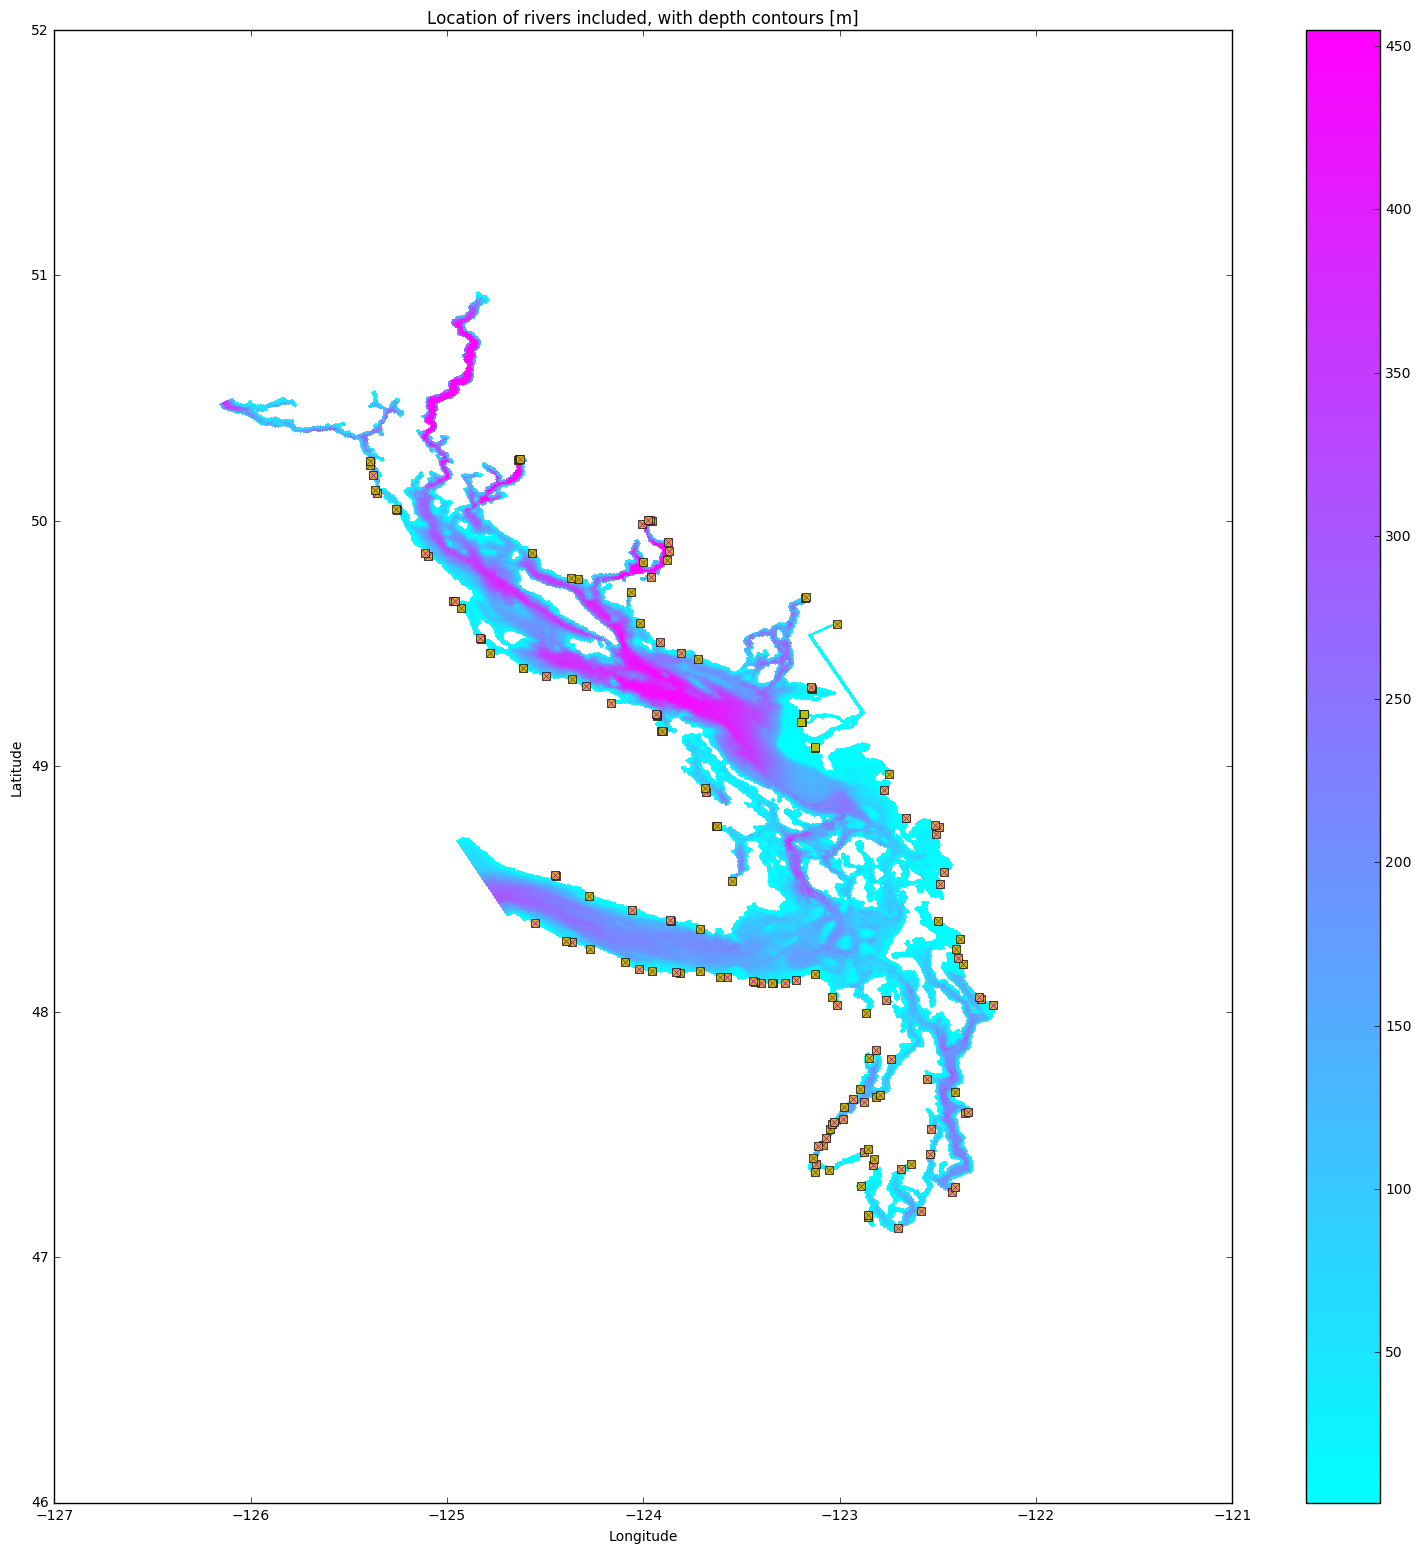

In [21]:
%matplotlib inline
Fraser = 8.10384 * e1t[500, 395] * e2t[500, 395]
test = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month_allArms.nc','r')
test2 = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month_extended.nc', 'r')
test3 = NC.Dataset('../../../NEMO-forcing/rivers/rivers_month.nc', 'r')

plotting = test.variables['rorunoff'][0, :, :]
plot2 = test2.variables['rorunoff'][0, :, :]
orig = test3.variables['rorunoff'][0, :, :]

plt.figure(figsize=(19, 19))
plt.pcolormesh(lon[:], lat[:], D, cmap='cool')
sumit1 = 0.
sumit2 = 0.
sumit3 = 0.
for i in range(0,800):
    for j in range(0,398):
        if plot2[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j],'ys')
        if plotting[i, j] > 0:
            plt.plot(lon[i,j], lat[i,j], 'mx')
        if plot2[i, j] != plotting[i, j] or plot2[i, j] != orig[i, j] or plotting[i, j] != orig[i, j]:
            sumit1 += e1t[i, j] * e2t[i, j] * plotting[i, j]/Fraser
            sumit2 += e1t[i, j] * e2t[i, j] * plot2[i, j]/Fraser
            sumit3 += e1t[i, j] * e2t[i, j] * orig[i ,j]/Fraser
            print (i, j, e1t[i, j] * e2t[i, j] * plotting[i, j]/Fraser,
                   e1t[i, j] * e2t[i, j] * plot2[i, j]/Fraser, 
                   e1t[i, j] * e2t[i, j] * orig[i, j]/Fraser, sumit1, sumit2, sumit3)
            
plt.colorbar()
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.title('Location of rivers included, with depth contours [m]')
plt.savefig('river_locations.pdf')


In [11]:
6.07788/8.10384

0.75

(12, 898, 398)
19.783


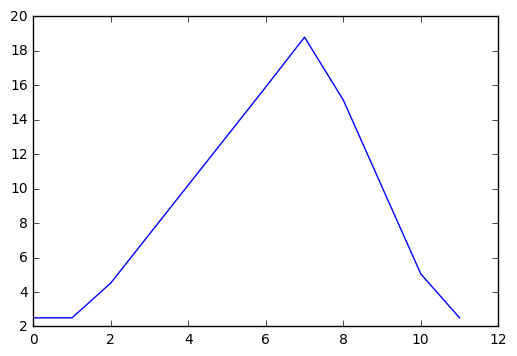

In [19]:
temp = test2.variables['rotemper'][:]
roro = test2.variables['rorunoff'][:]
print (temp.shape)
plt.plot(temp[:,351,345])
print (temp.max())

In [20]:
if rivertype == 'monthly':
    depths = D[roro[0] > 0.]
    ii, jj = np.where(roro[0] > 0.)
elif rivertype == 'constant':
    depths = D[roro > 0.]
    ii, jj = np.where(roro > 0.)

In [21]:
print (ii[depths.mask], jj[depths.mask])
ip = ii[depths.mask]; jp = jj[depths.mask]

[] []


IndexError: index 0 is out of bounds for axis 0 with size 0

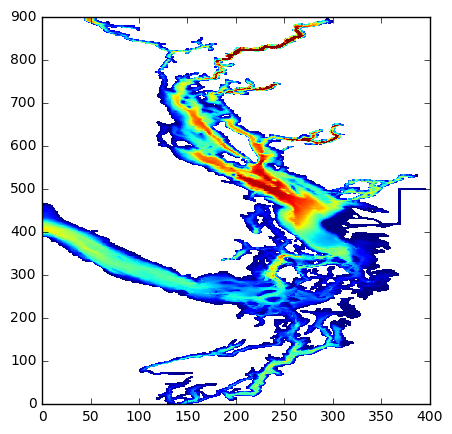

In [22]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[0], ip[0],'mo')
ax.set_xlim((35, 65))
ax.set_ylim((870, 898))
ax.plot(45+0.5, 891+0.5,'r*')

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.pcolormesh(D)
ax.plot(jp[:3], ip[:3],'mo')
ax.set_xlim((300, 320))
ax.set_ylim((635, 655))
ax.plot(307+0.5, 651+0.5,'r*')
ax.plot(309+0.5, 650+0.5,'r*')
ax.plot(310+0.5, 649+0.5,'r*')

In [23]:
test.close()
test2.close()
nemo.close()

RuntimeError: NetCDF: Not a valid ID